**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions. 

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [13]:
#Install Objax
!pip --quiet install  objax
import objax

In [14]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
print(X_train)
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]



Next we will construct a **Base Model**, which in our case is a small CNN.

In [4]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



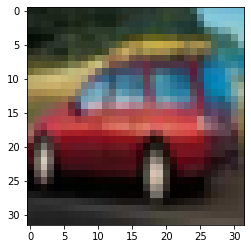

In [7]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [8]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

Filter weights: [[[[ 0.08896715 -0.07279256]
   [ 0.5039943  -0.5607323 ]
   [ 0.69289994 -0.86930597]]]]
Conv output: [[[[ 0.14117865  0.13613605  0.11829102 ...  1.0097966   0.9931872
     0.98468655]
   [ 0.19160458  0.16441517  0.16871695 ...  1.0254501   1.0205964
     1.0155538 ]
   [ 0.19664718  0.16639161  0.19392993 ...  1.0188706   1.0191027
     1.0148438 ]
   ...
   [ 0.22187413  0.21178894  0.21178894 ...  0.27654663  0.28158924
     0.29671702]
   [ 0.18657598  0.17649078  0.17649078 ...  0.3068022   0.30175963
     0.30175963]
   [ 0.1664056   0.161363    0.1664056  ...  0.37739852  0.37235594
     0.35722816]]

  [[-0.16435704 -0.15846358 -0.13737418 ... -1.1958665  -1.1757659
    -1.1652533 ]
   [-0.22329159 -0.19162536 -0.19630872 ... -1.2115611  -1.2058
    -1.1999066 ]
   [-0.22918504 -0.1938243  -0.225776   ... -1.2002045  -1.2009761
    -1.196932  ]
   ...
   [-0.259312   -0.24752508 -0.24752508 ... -0.31988704 -0.32578048
    -0.34346086]
   [-0.21805783 -0.20627

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [9]:
#Solution to the above problem
def my_conv_net(my_image, initial_filter_weights):
    print(my_image.shape)
    print(initial_filter_weights.shape)
    filter_size = [initial_filter_weights.shape[0], initial_filter_weights.shape[1]]
    filter_input_dim = initial_filter_weights.shape[2]
    filter_output_dim = initial_filter_weights.shape[3]
    print ( "filter_size", filter_size)
    print ( "filter_input_dim", filter_input_dim)
    print ("filter_output_dim" , filter_output_dim)

    filter = initial_filter_weights[0][0]
    image = my_image[0][0]
    image_dimension_x = image.shape[0]
    image_dimension_y = image.shape[1]
    imageNum = 0
    result = np.zeros( (imageNum+1, filter_output_dim, image_dimension_x, image_dimension_y) ) # store result

    for dimension in range(filter_output_dim):
        for channelNum, channel in enumerate(my_image[0]):
            for rowNum, row in enumerate(channel):
                for colNum, col in enumerate(channel):
                    result[imageNum][dimension][rowNum][colNum] +=  my_image[imageNum][channelNum][rowNum][colNum] * filter[channelNum][dimension]

    print("Conv output:", result)
    print("Conv output shape:", np.shape(result))
    my_conv_output = result
    return my_conv_output

my_conv_output = my_conv_net(my_image, filter_weights) #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

(1, 3, 32, 32)
(1, 1, 3, 2)
filter_size [1, 1]
filter_input_dim 3
filter_output_dim 2
Conv output: [[[[ 0.14117865  0.13613605  0.11829101 ...  1.00979662  0.99318719
     0.98468649]
   [ 0.19160458  0.16441518  0.16871697 ...  1.02544999  1.0205965
     1.01555383]
   [ 0.19664718  0.16639161  0.19392993 ...  1.01887059  1.01910257
     1.01484382]
   ...
   [ 0.22187412  0.21178894  0.21178894 ...  0.27654666  0.28158924
     0.29671702]
   [ 0.18657598  0.17649078  0.17649078 ...  0.30680221  0.3017596
     0.3017596 ]
   [ 0.16640559  0.16136301  0.16640559 ...  0.37739855  0.37235594
     0.35722816]]

  [[-0.16435704 -0.15846358 -0.13737418 ... -1.19586647 -1.17576587
    -1.16525328]
   [-0.22329159 -0.19162536 -0.19630872 ... -1.21156096 -1.20580006
    -1.19990659]
   [-0.22918504 -0.19382431 -0.225776   ... -1.20020449 -1.20097613
    -1.19693196]
   ...
   [-0.25931197 -0.24752508 -0.24752508 ... -0.31988704 -0.32578048
    -0.34346083]
   [-0.21805783 -0.2062709  -0.206270

**Show that the convolution routine returns the same value than Objax's.**

In [12]:
print('Compare the two outputs by looking at their mean difference', np.mean(np.absolute((my_conv_output - Conv2d(my_image)))))
print("Since the difference is near zero, we can see that the routine returns the smae value than Objax's")

Compare the two outputs by looking at their mean difference 8.64793e-09
Since the difference is near zero, we can see that the routine returns the smae value than Objax's


The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [ ]:
#Check that .mean((2,3)) rearranges your image
X = my_conv_output.mean((2,3))
print(X)

[[ 0.33567588 -0.33984361]]


Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



In [ ]:
X = my_conv_output.mean((2,3))
N = X.shape[1]
Linear_Layer = objax.nn.Linear(N,1)
Y = Linear_Layer(X)

w = Linear_Layer.w.value
b = Linear_Layer.b.value

#ONE LINE HERE
manual_Y = np.matmul(X,w)+b

print("manually_computed_Y", manual_Y, "Objax Y", Y)

manually_computed_Y [[-0.62935066]] Objax Y [[-0.62935066]]


Thus, since manually_computed_Y is [[-0.62935066]] and Objax Y is [[-0.62935066]], the values are the same.


**4. (1 point) Explain in a short paragraph what is the difference between the training and
validation set.**
- The difference between training and validation is the training data is used to train the machine learning model to learn its parameters (eg. feature weights) whereas the validation test set is used to provide an unbiased evaluation of a model that was fit on the training dataset so that hyperparameters of the model can be tuned.

You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

**1. (1 point) Complete the optimizer by using the definition of (stochastic) gradient descent:
wk+1 = wk−󰂃∇L(wk). Note that you need to update params.value, which are the values
of the trainable variables of your model.**

**2. (1 point) Complete the batch sampling code in the train function by specifying a batch
of examples. You should make use the lists train indices and val indices.**

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
        ####################
        #PUT YOUR CODE HERE#
        #################### 
        params.value = (params.value -learning_rate*grad)
        # params.value -= learning_rate*gradient
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

**3. (1 point) Train the model for a few epochs, and observe the training/validation loss and
training/validation accuracy plots. Include these plots within the PDF you hand in.
You should observe that the validation accuracy is low and stagnates after a few epochs.
Next we will go through a rudimentary way of adjusting the hyperparameters of the
model which we created.**

Epoch 0001  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 9.15 Validation Accuracy 8.83
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 11.14 Validation Accuracy 12.75
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 15.19 Validation Accuracy 16.02
Epoch 0004  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 16.30 Validation Accuracy 15.57
Epoch 0005  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 15.92 Validation Accuracy 15.70
Epoch 0006  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 15.80 Validation Accuracy 15.93
Epoch 0007  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 15.95 Validation Accuracy 15.97
Epoch 0008  Training Loss 2.26 Validation Loss 2.25 Training Accuracy 16.11 Validation Accuracy 16.48
Epoch 0009  Training Loss 2.25 Validation Loss 2.24 Training Accuracy 16.52 Validation Accuracy 16.43
Epoch 0010  Training Loss 2.24 Validation Loss 2.23 Training Accuracy 16.80 Validati

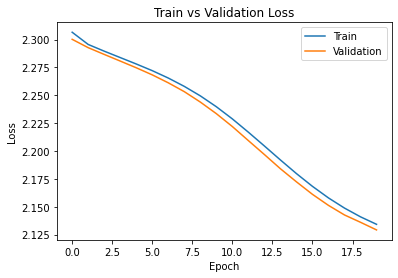

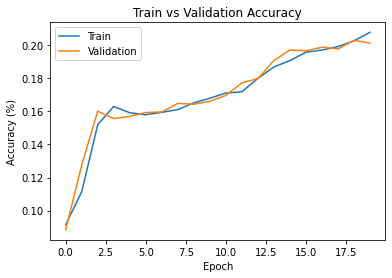

In [ ]:
train()

**4.(1 point) In one sentence, define the meaning of a “hyperparameter”. Explain in a short paragraph why it is important not to evaluate the accuracy on the test set until all hyperparameters have been tuned.**

Hyperparameters are values that are set before the training/optimization begins. This includes the learning rate.

We can measure the accuracy on the test set and say that the model achieves an accuracy of X% on images it has never seen before. Since, changing hyperparameters can change the performance of the whole model, we must fine tune all the hyperparameters for our model, which we do using our validation set, first. 

Extra: Ideally, we want to optimize the hyper-parameters to decrease the loss on the validation set (because increasing validiation loss means over-fitting). However, doing so, may cause us to over fit the hyperparameters to the validation set, meaning the loss may be low for the validation set but may increase for an unseen dataset. Thus, after tuning the hyperparameters using the validation set, we can then evaluate the accuracy on the test set, which will be unseen data, and can test the perfomance of our model on a new dataset only once, after training.







**5.(2 points) Select 4 hyperparameters associated with your network, one of the hyperparameter must involve your CNN architecture, and come up with two different sets of hyperparameters.**





* I selected the (1) learning rate, (2) batch size, (3) convolutional layers, and (4) activation function

1. Model 1 
    * Learning rate = 0.0001
    * Batch size = 16
    * activation function = relu
    * Convolutional layers = [Conv2D + relu] -> [Conv2D + relu] -> [linear]
2. Model 2
    * Learning rate = 0.001
    * Batch size = 32
    * activation function = relu
    * Convolutional layers = [Conv2D + relu] -> [Conv2D + relu] -> [Conv2D + batchNorm2D + relu + Conv2D + batchNorm2D + ralu ] -> [linear]

**6. 3 points) Create two additional networks M1,M2, each with the set of hyperparameter
H1, H2 that you have selected above. Train each model. Report the best validation
accuracy as well as the corresponding epoch for which this occurs for the Base Model
and your two additional models.**

**For example,
* Base model: 20% at epoch 22 M1: 30% at epoch 18 M2: 50% at epoch 24**

**Which model performs the best in terms of validation accuracy? These new models
do not need to outperform the base model, however, if you are unsatisfied with the
validation accuracy, adjust your hyperparameters in the previous part and train until
you are satisfied. Don’t forget to report your hyperparameters.**

- Report the best validation accuracy as well as the corresponding epoch for which this occurs for the Base Model and your two additional models.
    - Base model: 20.58% at epoch 20 
    - M1: 16.77% at epoch 14 
    - M2: 48% at epoch 20

    The M2 model performed the best in terms of validation accuracy. The test accuracy for M2 is:  0.5005. The average test loss for M2 is: 1.4005506954193114.

Model 1 / M1
* Learning rate = 0.0001
* Batch size = 16
* activation function = relu
* Convolutional layers = [Conv2D + relu] -> [Conv2D + relu] -> [linear]

In [ ]:
class ConvNet2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet2()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
        ####################
        #PUT YOUR CODE HERE#
        #################### 
        params.value = (params.value -learning_rate*grad)
        # params.value -= learning_rate*gradient
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.36 Validation Loss 2.33 Training Accuracy 9.96 Validation Accuracy 10.28
Epoch 0002  Training Loss 2.33 Validation Loss 2.32 Training Accuracy 9.96 Validation Accuracy 10.28
Epoch 0003  Training Loss 2.32 Validation Loss 2.31 Training Accuracy 10.03 Validation Accuracy 10.43
Epoch 0004  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 10.36 Validation Accuracy 10.92
Epoch 0005  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 10.96 Validation Accuracy 11.90
Epoch 0006  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.95 Validation Accuracy 13.00
Epoch 0007  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 12.99 Validation Accuracy 13.97
Epoch 0008  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.79 Validation Accuracy 14.88
Epoch 0009  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 14.87 Validation Accuracy 15.65
Epoch 0010  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 15.60 Validati

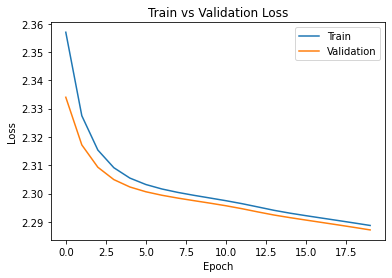

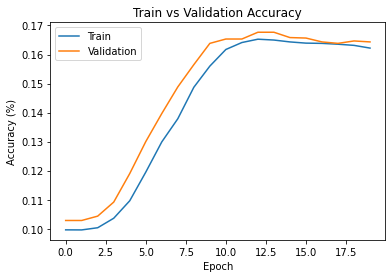

In [ ]:
train(20, 16,0.0001) # batch size 32, epoch 40, learning rate 0.001

Model 2 / M2
> 
* Learning rate = 0.001
* Batch size = 32
* activation function = relu
* Convolutional layers = [Conv2D + relu] -> [Conv2D + relu] -> [Conv2D + batchNorm2D + relu + Conv2D + batchNorm2D + ralu ] -> [linear]




In [ ]:
class ConvNet3(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 16, 2), objax.functional.relu])
    self.conv_block3 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2, use_bias=False),
                                            objax.nn.BatchNorm2D(32),
                                            objax.functional.relu,
                                            objax.nn.Conv2D(32, 32, 2, use_bias=False),
                                            objax.nn.BatchNorm2D(32),
                                            objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x, training):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_block3(x, training=training)
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet3()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x, training=True)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x, training=True)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
        ####################
        #PUT YOUR CODE HERE#
        #################### 
        params.value = (params.value -learning_rate*grad)
        # params.value -= learning_rate*gradient
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.23 Validation Loss 2.13 Training Accuracy 18.10 Validation Accuracy 23.98
Epoch 0002  Training Loss 2.08 Validation Loss 2.03 Training Accuracy 25.74 Validation Accuracy 26.50
Epoch 0003  Training Loss 1.98 Validation Loss 1.94 Training Accuracy 28.70 Validation Accuracy 30.22
Epoch 0004  Training Loss 1.90 Validation Loss 1.86 Training Accuracy 32.24 Validation Accuracy 32.62
Epoch 0005  Training Loss 1.84 Validation Loss 1.81 Training Accuracy 34.76 Validation Accuracy 34.57
Epoch 0006  Training Loss 1.78 Validation Loss 1.76 Training Accuracy 36.85 Validation Accuracy 36.30
Epoch 0007  Training Loss 1.74 Validation Loss 1.72 Training Accuracy 38.56 Validation Accuracy 37.58
Epoch 0008  Training Loss 1.70 Validation Loss 1.68 Training Accuracy 39.83 Validation Accuracy 38.80
Epoch 0009  Training Loss 1.67 Validation Loss 1.66 Training Accuracy 40.98 Validation Accuracy 39.75
Epoch 0010  Training Loss 1.63 Validation Loss 1.63 Training Accuracy 42.41 Valida

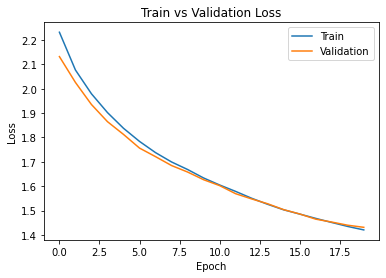

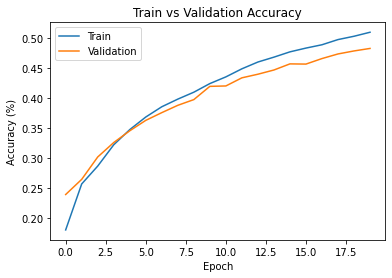

In [ ]:
train(20, 16, 0.001)

**7. (2 points) Based on your answer, which model should you pick as your final model and
why? Then evaluate your model on the test set and report final test accuracy.**


I would select the M2 model since it performs the best in validation ACCURACY.

In [ ]:
# run test and get accuracy
avg_test_loss = 0
test_acc = 0
BATCH = 32 #M2
test_indices = np.arange(len(X_test)) 
np.random.shuffle(test_indices)    
for it in range(0, X_test.shape[0], BATCH):
    batch = test_indices[it:it+BATCH]
    avg_test_loss += float(loss_function(X_test[batch], Y_test[batch])) * len(batch)
    test_prediction = predict(X_test[batch]).argmax(1)
    test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
test_acc = (test_acc/X_test.shape[0])
avg_test_loss = (avg_test_loss/X_test.shape[0])

In [ ]:
print("the test accuracy for M2 is: ", test_acc)
print("the average test loss for M2 is:", avg_test_loss)

the test accuracy for M2 is:  0.5005
the average test loss for M2 is: 1.4005506954193114


You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.

To solidify your knowledge of training and tuning
of a CNN, you will run another set of experiments on a new dataset. It should closely follow
what you have done in Part 2. You will develop your own network to classify the data
included in the dataset you picked. You may re-use any part of the starter code (e.g., for
dataloading).

Pick a dataset of your own choosing from the following link (under “Image classification”):
https://www.tensorflow.org/datasets/catalog/overview


In [ ]:
pip install -q tfds-nightly tensorflow matplotlib

     |████████████████████████████████| 4.9 MB 8.4 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

**1. (1 point) Import and partition your data.**

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteCNWILF/rock_paper_scissors-train.tfrec…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteCNWILF/rock_paper_scissors-test.tfreco…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
Train set size:  2520
Test set size:  372
Val set size:  378


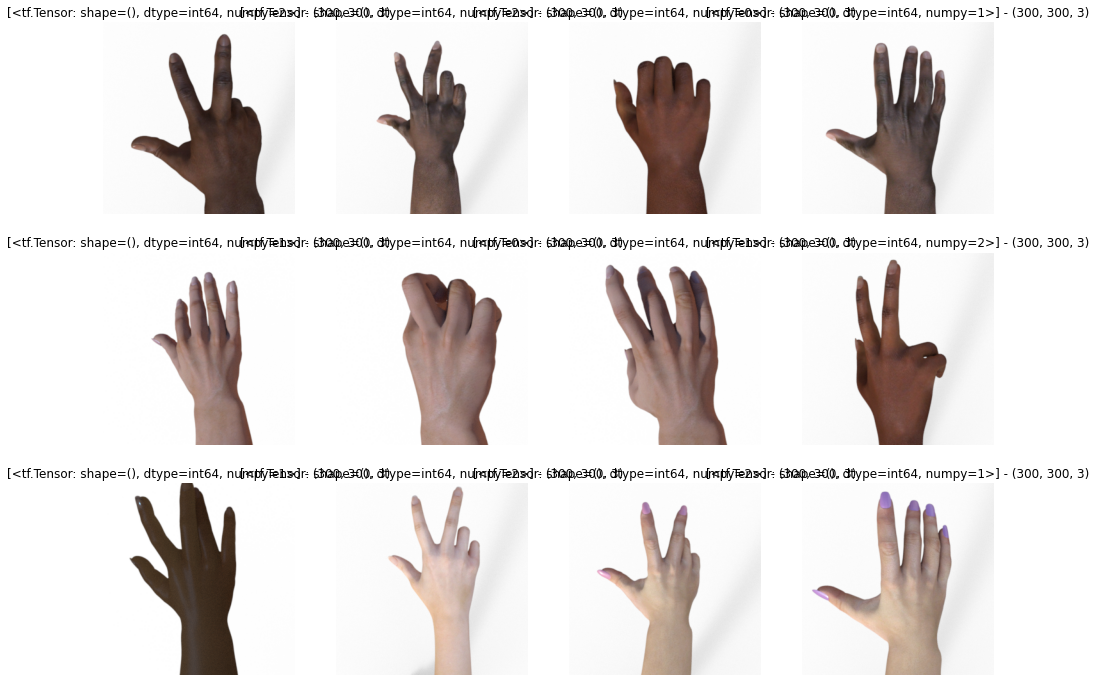

(2520, 3, 300, 300)


In [ ]:
# Returns both train and test split separately
train_set, val_set, test_set = tfds.load('rock_paper_scissors', split=['train', 'train[85%:]', 'test'], shuffle_files=True,  as_supervised=True)
print("Train set size: ", len(train_set)) # Train set size:  70%
print("Test set size: ", len(test_set))   # Test set size:  15%
print("Val set size: ", len(val_set))   # Test set size:  15%


def display_dataset_images(ds, nrows=3, ncols=4, figsize=(16,12)):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs = np.ravel(axs)
    i = 0
    for image, label in ds.take(len(axs)):
        plt.sca(axs[i])
        plt.imshow(image.numpy())
        plt.title(f"{[label]} - {image.numpy().shape}")
        plt.axis('off')
        i+=1
    plt.show()

display_dataset_images(train_set)

X_train = []
Y_train = []
X_test = []
Y_test = []
X_valid = []
Y_valid = []

for image, label in train_set: 
    X_train.append(image.numpy())
    Y_train.append(label)
X_train = np.stack(X_train, axis=0)
Y_train = np.array(Y_train)

X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()

for image, label in test_set: 
    X_test.append(image.numpy())
    Y_test.append(label)
X_test = np.stack(X_test, axis=0)
Y_test = np.array(Y_test)

X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()
  
for image, label in val_set: 
    X_valid.append(image.numpy())
    Y_valid.append(label)
X_valid = np.stack(X_valid, axis=0)
Y_valid = np.array(Y_valid)

X_valid = X_valid.transpose(0, 3, 1, 2) / 255.0
Y_valid = Y_valid.flatten()

print(X_train.shape)


**2. (1 point) Create a base model to start out with**

In [ ]:
class ConvNet_base_rock_paper_scissors(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 3):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 150, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(150, 300, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(300, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet_base_rock_paper_scissors()
#You can examine the architecture of our CNN by calling model.vars()

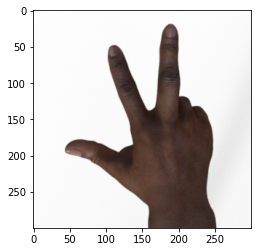

In [ ]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
        params.value = (params.value -learning_rate*grad)
        # params.value -= learning_rate*gradient
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

**3. (3 points) Pick several hyperparameters you would like to tune and train a model until
its validation accuracy is 5-10% better than the base model. Provide a succinct discussion
on your design procedure: which hyperparameters you tuned, what is the new validation
accuracy.**




I tuned the convolutional layer and played around with adding more and less layers as seen in model 2. I used  [Conv2D + batchNorm2D + relu + Conv2D + batchNorm2D + ralu ]. This improved the validation accuracy from model 1 to model 2 by 44.7%.

**Model 1**
1. Learning rate = 9e-4
2. Batch size = 32
3. Num of epochs = 20
4. Convolutional layers = [Conv2D + relu] -> [Conv2D + relu] -> [linear]

    Best performance @ epoch 0017 
    *  Training Loss 1.10, 
    * Validation Loss 1.10
    *  Training Accuracy 37.98 
    * Validation Accuracy 33.86


**Model 2**
1. Learning rate = 9e-4
2. Batch size = 32
3. Num of epochs = 20
4. Convolutional layers = [Conv2D + relu] -> [Conv2D + relu] -> [Conv2D + batchNorm2D + relu + Conv2D + batchNorm2D + ralu ] -> [linear]

    Best performance @ epoch 0020  
    * Training Loss 0.77 
    * Validation Loss 0.78 
    * Training Accuracy 80.91 
    * Validation Accuracy 79.63


In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 1.10 Validation Loss 1.10 Training Accuracy 36.27 Validation Accuracy 33.86
Epoch 0002  Training Loss 1.10 Validation Loss 1.10 Training Accuracy 36.94 Validation Accuracy 33.33
Epoch 0003  Training Loss 1.10 Validation Loss 1.10 Training Accuracy 35.71 Validation Accuracy 33.33
Epoch 0004  Training Loss 1.10 Validation Loss 1.10 Training Accuracy 36.90 Validation Accuracy 33.33
Epoch 0005  Training Loss 1.10 Validation Loss 1.10 Training Accuracy 36.79 Validation Accuracy 33.86
Epoch 0006  Training Loss 1.10 Validation Loss 1.10 Training Accuracy 36.03 Validation Accuracy 32.80
Epoch 0007  Training Loss 1.10 Validation Loss 1.10 Training Accuracy 36.03 Validation Accuracy 33.86
Epoch 0008  Training Loss 1.10 Validation Loss 1.10 Training Accuracy 36.59 Validation Accuracy 32.80
Epoch 0009  Training Loss 1.10 Validation Loss 1.10 Training Accuracy 36.55 Validation Accuracy 33.86
Epoch 0010  Training Loss 1.10 Validation Loss 1.10 Training Accuracy 36.67 Valida

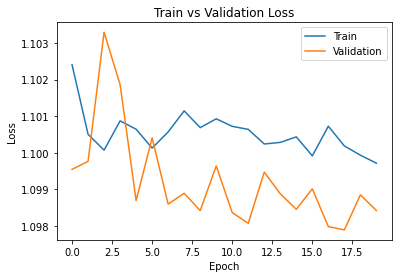

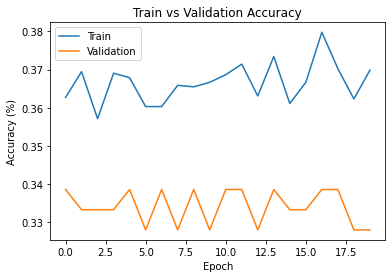

In [ ]:
train()

In [ ]:
class ConvNet_m2_scissors(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 3):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 150, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(150, 150, 2), objax.functional.relu])
    self.conv_block3 = objax.nn.Sequential([objax.nn.Conv2D(150, 300, 2, use_bias=False),
                                            objax.nn.BatchNorm2D(300),
                                            objax.functional.relu,
                                            objax.nn.Conv2D(300, 300, 2, use_bias=False),
                                            objax.nn.BatchNorm2D(300),
                                            objax.functional.relu])
    self.linear = objax.nn.Linear(300, number_of_classes)

  def __call__(self, x, training):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_block3(x, training=training)
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet_m2_scissors()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x, training=True)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x, training=True)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
        ####################
        #PUT YOUR CODE HERE#
        #################### 
        params.value = (params.value -learning_rate*grad)
        # params.value -= learning_rate*gradient
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 1.11 Validation Loss 1.04 Training Accuracy 40.52 Validation Accuracy 45.24
Epoch 0002  Training Loss 1.02 Validation Loss 1.01 Training Accuracy 60.32 Validation Accuracy 60.05
Epoch 0003  Training Loss 0.99 Validation Loss 0.99 Training Accuracy 65.24 Validation Accuracy 62.70
Epoch 0004  Training Loss 0.98 Validation Loss 0.97 Training Accuracy 67.46 Validation Accuracy 61.11
Epoch 0005  Training Loss 0.96 Validation Loss 0.95 Training Accuracy 69.37 Validation Accuracy 70.11
Epoch 0006  Training Loss 0.94 Validation Loss 0.93 Training Accuracy 70.91 Validation Accuracy 69.31
Epoch 0007  Training Loss 0.93 Validation Loss 0.92 Training Accuracy 72.42 Validation Accuracy 70.90
Epoch 0008  Training Loss 0.91 Validation Loss 0.90 Training Accuracy 72.06 Validation Accuracy 70.11
Epoch 0009  Training Loss 0.90 Validation Loss 0.89 Training Accuracy 73.65 Validation Accuracy 71.43
Epoch 0010  Training Loss 0.88 Validation Loss 0.88 Training Accuracy 74.80 Valida

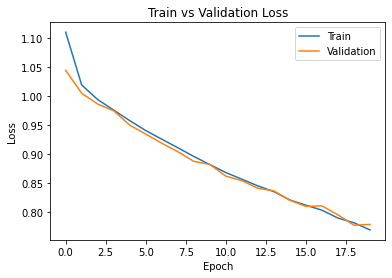

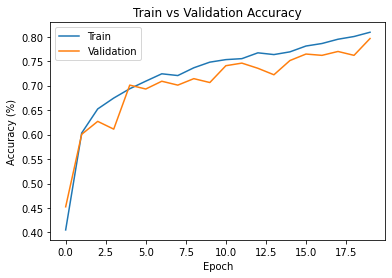

In [ ]:
train()

**4. (1 point) Select your final model and report test accuracy.**

In [ ]:
# run test and get accuracy
avg_test_loss = 0
test_acc = 0
BATCH = 32 #M2
test_indices = np.arange(len(X_test)) 
np.random.shuffle(test_indices)    
for it in range(0, X_test.shape[0], BATCH):
    batch = test_indices[it:it+BATCH]
    avg_test_loss += float(loss_function(X_test[batch], Y_test[batch])) * len(batch)
    test_prediction = predict(X_test[batch]).argmax(1)
    test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
test_acc = (test_acc/X_test.shape[0])
avg_test_loss = (avg_test_loss/X_test.shape[0])

In [ ]:
print("the test accuracy for the baseline model is: ", test_acc)
print("the average test loss for baseline is:", avg_test_loss)

the test accuracy for the baseline model is:  0.48118279569892475
the average test loss for baseline is: 1.0558771471823416


##**Problem 4. Open-Ended Exploration**
#### **I am choosing to build off of part 2 and the cifar10 dataset!**

Model 2 / M2
> 
* Learning rate = 0.001
* Batch size = 32
* activation function = relu
* Convoultional layers = [Conv2D + relu] -> [Conv2D + relu] -> [Conv2D + batchNorm2D + relu + Conv2D + batchNorm2D + ralu ] -> [linear]




**base model**

Epoch 0001  Training Loss 2.38 Validation Loss 2.36 Training Accuracy 9.81 Validation Accuracy 9.72
Epoch 0002  Training Loss 2.35 Validation Loss 2.33 Training Accuracy 9.81 Validation Accuracy 9.72
Epoch 0003  Training Loss 2.32 Validation Loss 2.31 Training Accuracy 9.78 Validation Accuracy 9.98
Epoch 0004  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 10.14 Validation Accuracy 11.05
Epoch 0005  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.28 Validation Accuracy 12.35
Epoch 0006  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 12.76 Validation Accuracy 14.07
Epoch 0007  Training Loss 2.25 Validation Loss 2.25 Training Accuracy 14.57 Validation Accuracy 15.05
Epoch 0008  Training Loss 2.24 Validation Loss 2.23 Training Accuracy 15.82 Validation Accuracy 16.23
Epoch 0009  Training Loss 2.23 Validation Loss 2.22 Training Accuracy 17.38 Validation Accuracy 17.17
Epoch 0010  Training Loss 2.22 Validation Loss 2.21 Training Accuracy 18.55 Validation A

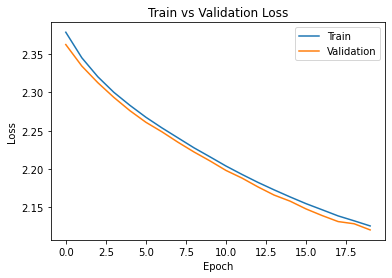

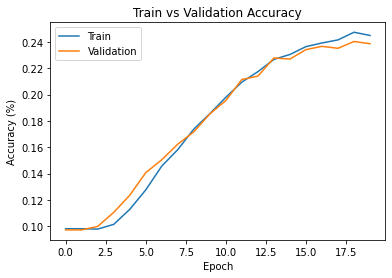

In [ ]:
train(20, 32, 0.0001)

In [24]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
print(X_train)
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]


[[[[0.23137255 0.16862745 0.19607843 ... 0.61960784 0.59607843
    0.58039216]
   [0.0627451  0.         0.07058824 ... 0.48235294 0.46666667
    0.47843137]
   [0.09803922 0.0627451  0.19215686 ... 0.4627451  0.47058824
    0.42745098]
   ...
   [0.81568627 0.78823529 0.77647059 ... 0.62745098 0.21960784
    0.20784314]
   [0.70588235 0.67843137 0.72941176 ... 0.72156863 0.38039216
    0.3254902 ]
   [0.69411765 0.65882353 0.70196078 ... 0.84705882 0.59215686
    0.48235294]]

  [[0.24313725 0.18039216 0.18823529 ... 0.51764706 0.49019608
    0.48627451]
   [0.07843137 0.         0.03137255 ... 0.34509804 0.3254902
    0.34117647]
   [0.09411765 0.02745098 0.10588235 ... 0.32941176 0.32941176
    0.28627451]
   ...
   [0.66666667 0.6        0.63137255 ... 0.52156863 0.12156863
    0.13333333]
   [0.54509804 0.48235294 0.56470588 ... 0.58039216 0.24313725
    0.20784314]
   [0.56470588 0.50588235 0.55686275 ... 0.72156863 0.4627451
    0.36078431]]

  [[0.24705882 0.17647059 0.16862745

In [25]:
class ConvNet3(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 16, 2), objax.functional.relu])
    self.conv_block3 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2, use_bias=False),
                                            objax.nn.BatchNorm2D(32),
                                            objax.functional.relu,
                                            objax.nn.Conv2D(32, 32, 2, use_bias=False),
                                            objax.nn.BatchNorm2D(32),
                                            objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x, training):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_block3(x, training=training)
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet3()
#You can examine the architecture of our CNN by calling model.vars()

In [26]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x, training=True)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x, training=True)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
        ####################
        #PUT YOUR CODE HERE#
        #################### 
        params.value = (params.value -learning_rate*grad)
        # params.value -= learning_rate*gradient
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [27]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Model A: Decrease learning rate from base model. 
- Result: It has better validation accuracy

Epoch 0001  Training Loss 1.37 Validation Loss 1.38 Training Accuracy 51.76 Validation Accuracy 49.70
Epoch 0002  Training Loss 1.37 Validation Loss 1.38 Training Accuracy 52.24 Validation Accuracy 49.97
Epoch 0003  Training Loss 1.36 Validation Loss 1.38 Training Accuracy 52.33 Validation Accuracy 50.22
Epoch 0004  Training Loss 1.35 Validation Loss 1.36 Training Accuracy 52.84 Validation Accuracy 50.47
Epoch 0005  Training Loss 1.35 Validation Loss 1.36 Training Accuracy 52.68 Validation Accuracy 50.47
Epoch 0006  Training Loss 1.34 Validation Loss 1.35 Training Accuracy 53.07 Validation Accuracy 50.77
Epoch 0007  Training Loss 1.33 Validation Loss 1.34 Training Accuracy 53.80 Validation Accuracy 50.67
Epoch 0008  Training Loss 1.32 Validation Loss 1.34 Training Accuracy 53.97 Validation Accuracy 50.93
Epoch 0009  Training Loss 1.32 Validation Loss 1.34 Training Accuracy 53.96 Validation Accuracy 50.88
Epoch 0010  Training Loss 1.31 Validation Loss 1.33 Training Accuracy 54.30 Valida

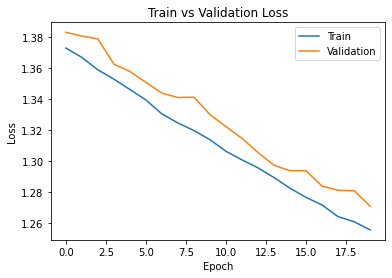

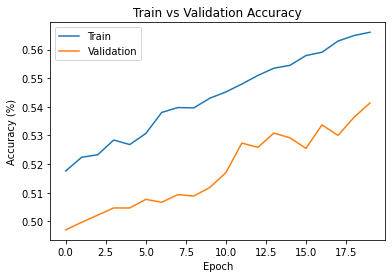

In [ ]:
train(20, 32, 0.001)

Model B: Decrease batch size

Rsult: It has better validation accuracy than the base model by ~5%

Epoch 0001  Training Loss 2.04 Validation Loss 2.04 Training Accuracy 26.55 Validation Accuracy 26.63
Epoch 0002  Training Loss 2.03 Validation Loss 2.03 Training Accuracy 27.03 Validation Accuracy 26.52
Epoch 0003  Training Loss 2.02 Validation Loss 2.02 Training Accuracy 27.21 Validation Accuracy 27.37
Epoch 0004  Training Loss 2.02 Validation Loss 2.02 Training Accuracy 27.63 Validation Accuracy 26.95
Epoch 0005  Training Loss 2.01 Validation Loss 2.00 Training Accuracy 27.95 Validation Accuracy 27.55
Epoch 0006  Training Loss 2.00 Validation Loss 2.00 Training Accuracy 28.32 Validation Accuracy 28.10
Epoch 0007  Training Loss 2.00 Validation Loss 1.99 Training Accuracy 28.46 Validation Accuracy 28.30
Epoch 0008  Training Loss 1.99 Validation Loss 1.99 Training Accuracy 28.44 Validation Accuracy 28.13
Epoch 0009  Training Loss 1.98 Validation Loss 1.98 Training Accuracy 28.90 Validation Accuracy 28.37
Epoch 0010  Training Loss 1.98 Validation Loss 1.97 Training Accuracy 29.19 Valida

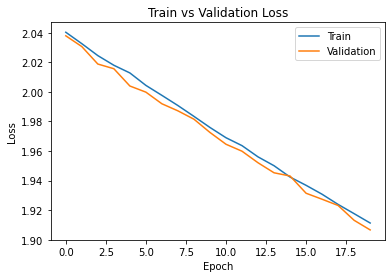

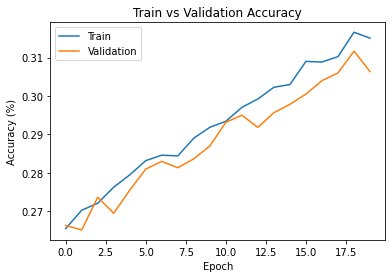

In [22]:
train(20, 20, 0.0001)

Model C: decrease batch size AND decrease learning rate
- Result: It has does **not** have a better final validation accuracy than that of Model A and B, where we individually decreased the learning rate and decrease batch size, respectively,

Epoch 0001  Training Loss 2.24 Validation Loss 2.14 Training Accuracy 17.52 Validation Accuracy 20.32
Epoch 0002  Training Loss 2.10 Validation Loss 2.06 Training Accuracy 22.75 Validation Accuracy 25.00
Epoch 0003  Training Loss 2.03 Validation Loss 2.00 Training Accuracy 26.66 Validation Accuracy 27.73
Epoch 0004  Training Loss 1.97 Validation Loss 1.95 Training Accuracy 29.01 Validation Accuracy 28.95
Epoch 0005  Training Loss 1.92 Validation Loss 1.89 Training Accuracy 30.80 Validation Accuracy 31.02
Epoch 0006  Training Loss 1.87 Validation Loss 1.84 Training Accuracy 33.13 Validation Accuracy 33.15
Epoch 0007  Training Loss 1.82 Validation Loss 1.79 Training Accuracy 35.10 Validation Accuracy 34.88
Epoch 0008  Training Loss 1.77 Validation Loss 1.75 Training Accuracy 36.76 Validation Accuracy 36.25
Epoch 0009  Training Loss 1.73 Validation Loss 1.72 Training Accuracy 38.32 Validation Accuracy 37.98
Epoch 0010  Training Loss 1.70 Validation Loss 1.69 Training Accuracy 39.62 Valida

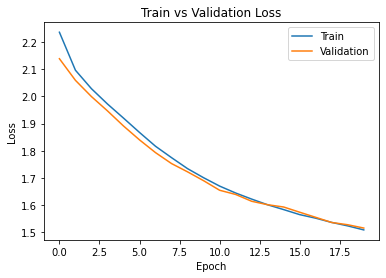

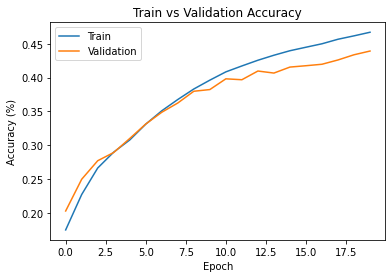

In [28]:
train(20, 20, 0.001)

In [ ]:
# run test and get accuracy
avg_test_loss = 0
test_acc = 0
BATCH = 32 #M2
test_indices = np.arange(len(X_test)) 
np.random.shuffle(test_indices)    
for it in range(0, X_test.shape[0], BATCH):
    batch = test_indices[it:it+BATCH]
    avg_test_loss += float(loss_function(X_test[batch], Y_test[batch])) * len(batch)
    test_prediction = predict(X_test[batch]).argmax(1)
    test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
test_acc = (test_acc/X_test.shape[0])
avg_test_loss = (avg_test_loss/X_test.shape[0])

**Report the final model and its test accuracy**

final perfomance of the best Model A, where we decreased the learning rate from 0.0001 to 0.001.
* train(20, 16, 0.001) 
* test_acc = 51.066%
* aver_test_loss = 1.368


In [ ]:
print("the test accuracy for the best model is: ", test_acc)
print("the average test loss for the best model is:", avg_test_loss)